<a href="https://colab.research.google.com/github/krishnaaxo/DogeCoin_Forecasting_Prophet_TimeSeries/blob/main/doge_coin_to_moon_eda_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1><center style="background-color:#6A5ACD; color:white;"> Dogecoin Historical Data Analysis</center></h1>
</div>

In [34]:
pip install colorama

In [35]:

#Data Pre-Processing packages:
import numpy as np 
import pandas as pd 
from datetime import datetime


#Data Visualization Packages:
#Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

#Colorama
from colorama import Fore, Back, Style # For text colors
y_= Fore.CYAN
m_= Fore.WHITE

#NetworkX
import networkx as nx
import plotly.graph_objects as go #To construct network graphs

#To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#Time series Analysis pacakages:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Facebook Prophet packages:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


data=pd.read_csv('/content/DOGE-USD.csv')



In [36]:
print(f"{m_}Total records:{y_}{data.shape}\n")
print(f"{m_}Data types of data columns: \n{y_}{data.dtypes}")

Total records:(2428, 7)

Data types of data columns: 
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [37]:
# Coverting the date column to a datetime format and sorting the dataframe by date
data['Date'] =  pd.to_datetime(data['Date'],infer_datetime_format=True,format='%y-%m-%d')
data.sort_values(by='Date',inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0
1,2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0
2,2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0
3,2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0
4,2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0


<div class="alert alert-info">
    <h3><b><center>Missing values</center><b></h3>
</div>


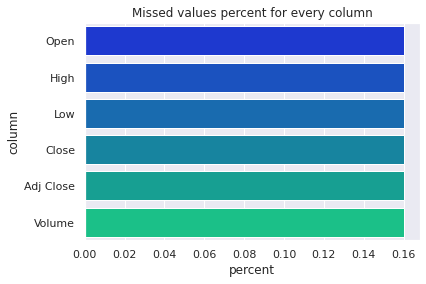

In [38]:
missed = pd.DataFrame()
missed['column'] = data.columns

missed['percent'] = [round(100* data[col].isnull().sum() / len(data), 2) for col in data.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]

fig = sns.barplot(
    x=missed['percent'], 
    y=missed["column"], 
    orientation='horizontal',palette="winter"
).set_title('Missed values percent for every column')

<div class="alert alert-info">
    <h3><b>Let's drop the records with NA value, to make sure it doesnt cloud our analysis<b></h3>
</div>


In [39]:
prev_len=data.shape[0]
data=data.dropna()
print(f"{m_}Total records after the removal of NA values: {y_}{data.shape}\n")
print(f"{m_}Removed records:{y_}{prev_len-data.shape[0]}\n")
print(f"{m_}Removed records percentage:{y_}{round(((prev_len-data.shape[0])/prev_len)*100,2)}")

Total records after the removal of NA values: (2424, 7)

Removed records:4

Removed records percentage:0.16


<a id="3"></a>
<h2 style='background-color:#6A5ACD; border:0; color:black'><center>Distribution of Features</center><h2>

<div class="alert alert-info">
    <h3><b>Let's Visualize the distribution of the key variables like Opening price, Highest price, Lowest price and Closing price in Dogecoin<b></h3>
</div>


In [40]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(20,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

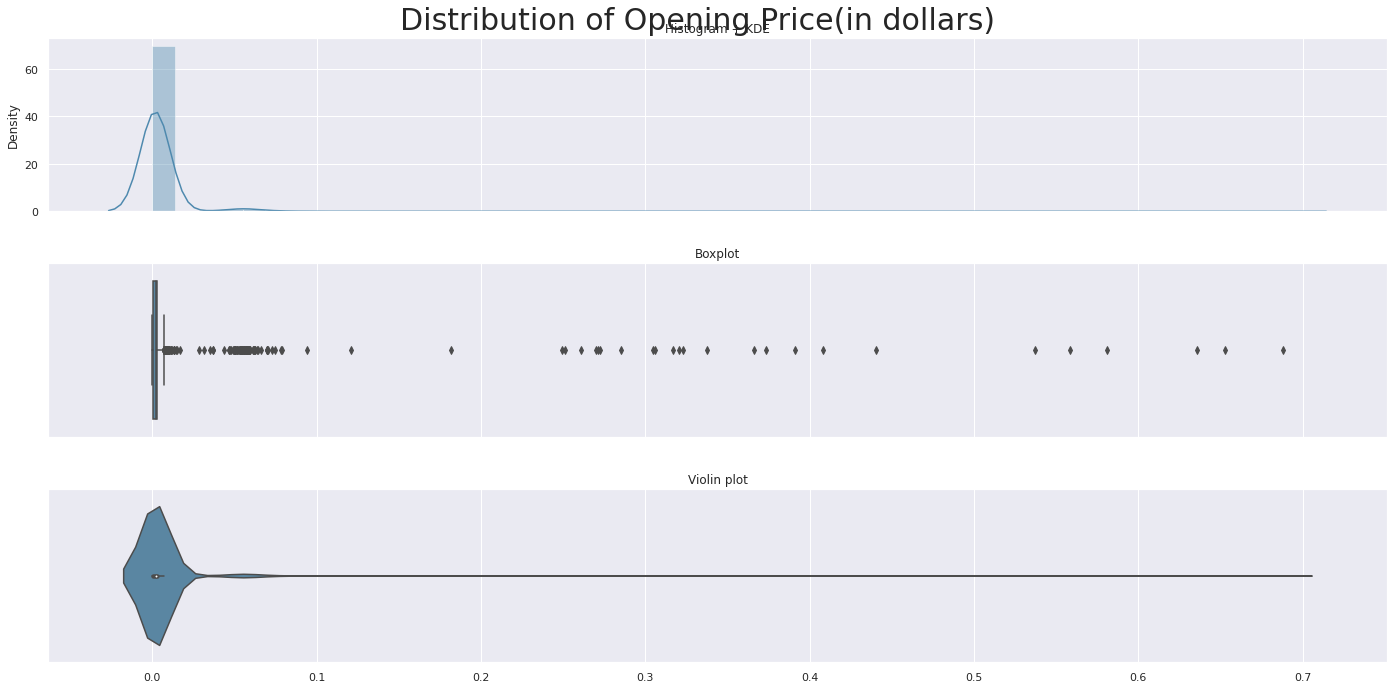

In [41]:
triple_plot(data['Open'],'Distribution of Opening Price(in dollars)',custom_colors[0])

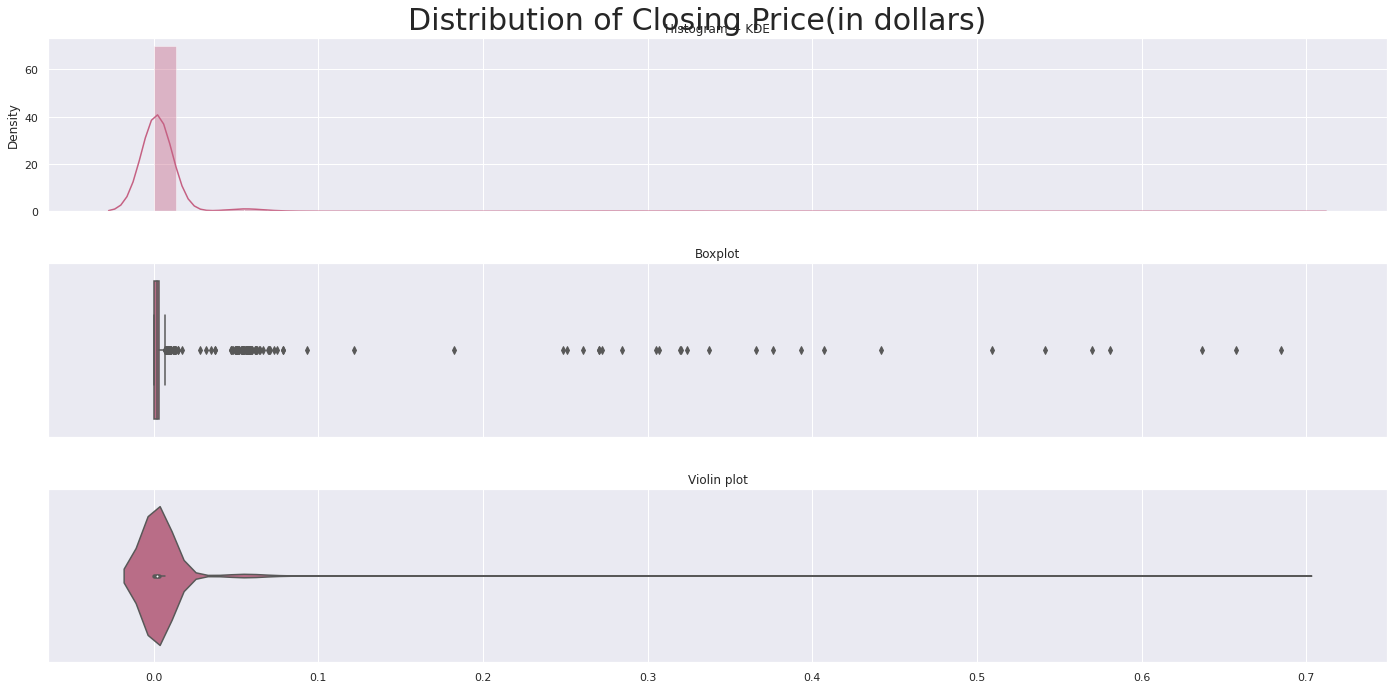

In [42]:
triple_plot(data['Close'],'Distribution of Closing Price(in dollars)',custom_colors[1])

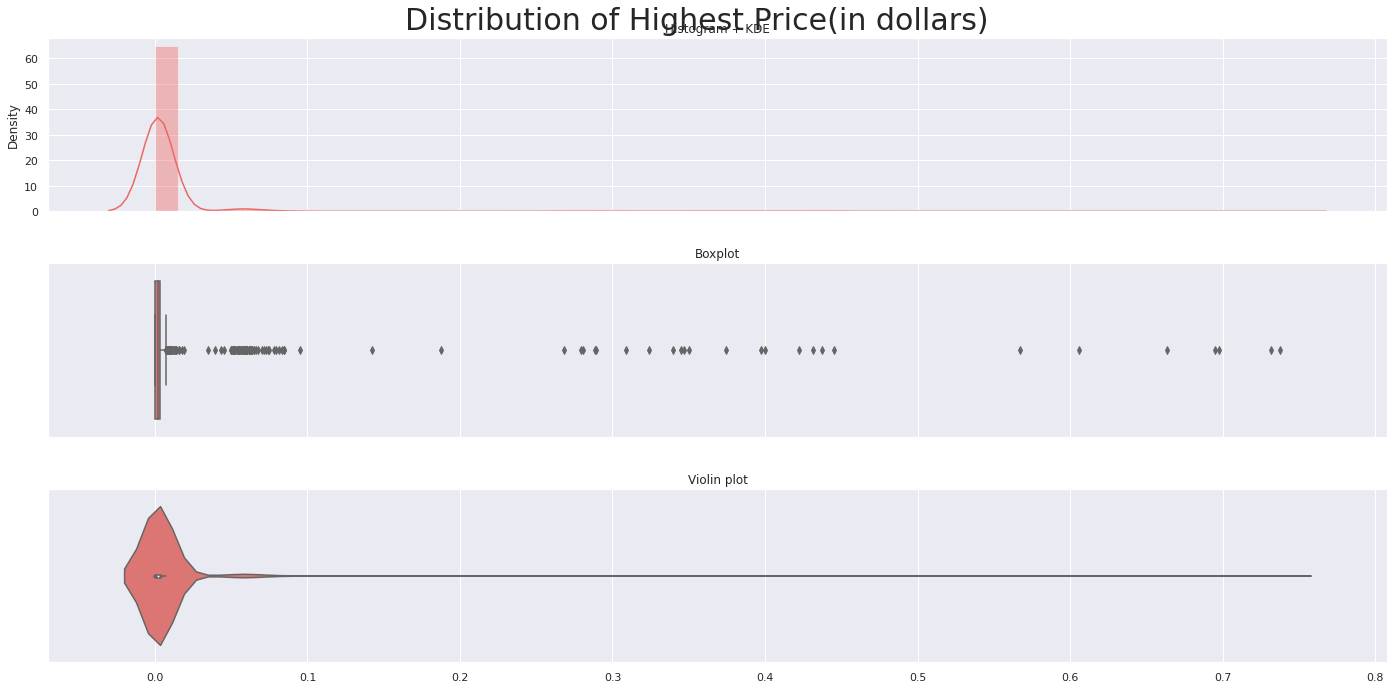

In [43]:
triple_plot(data['High'],'Distribution of Highest Price(in dollars)',custom_colors[2])

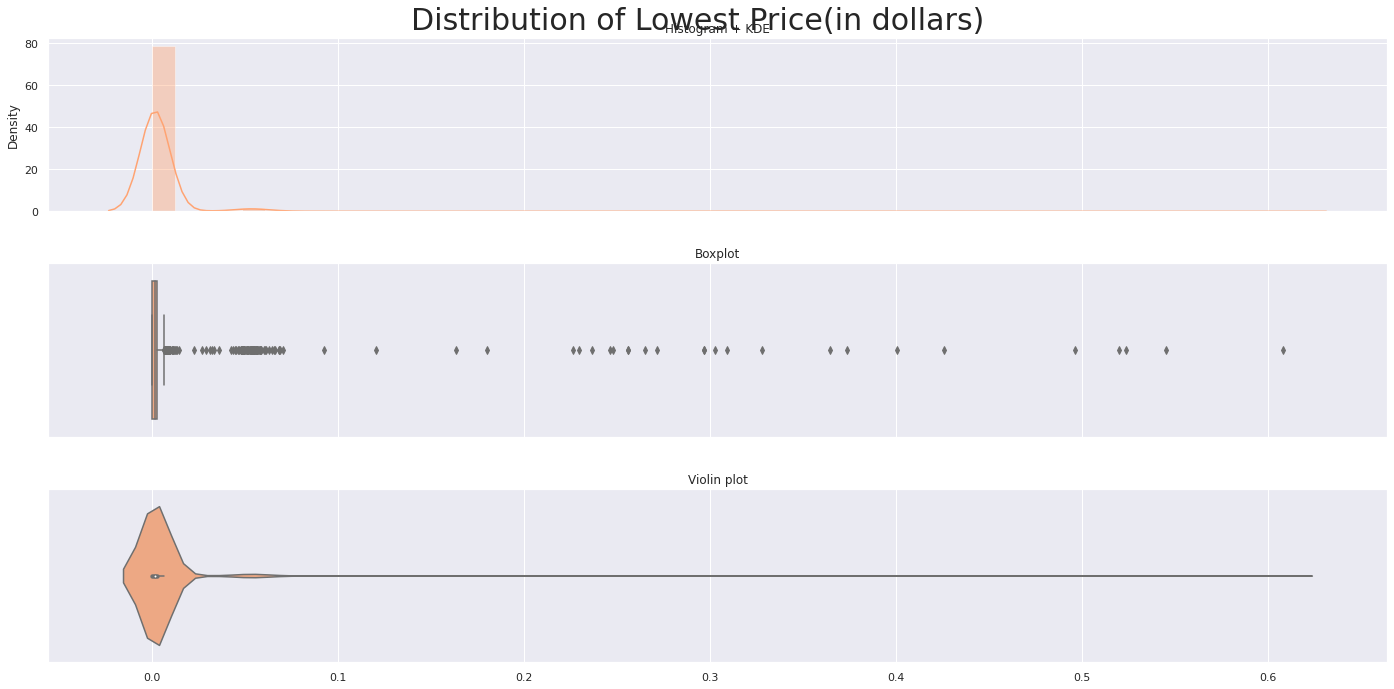

In [44]:
triple_plot(data['Low'],'Distribution of Lowest Price(in dollars)',custom_colors[3])

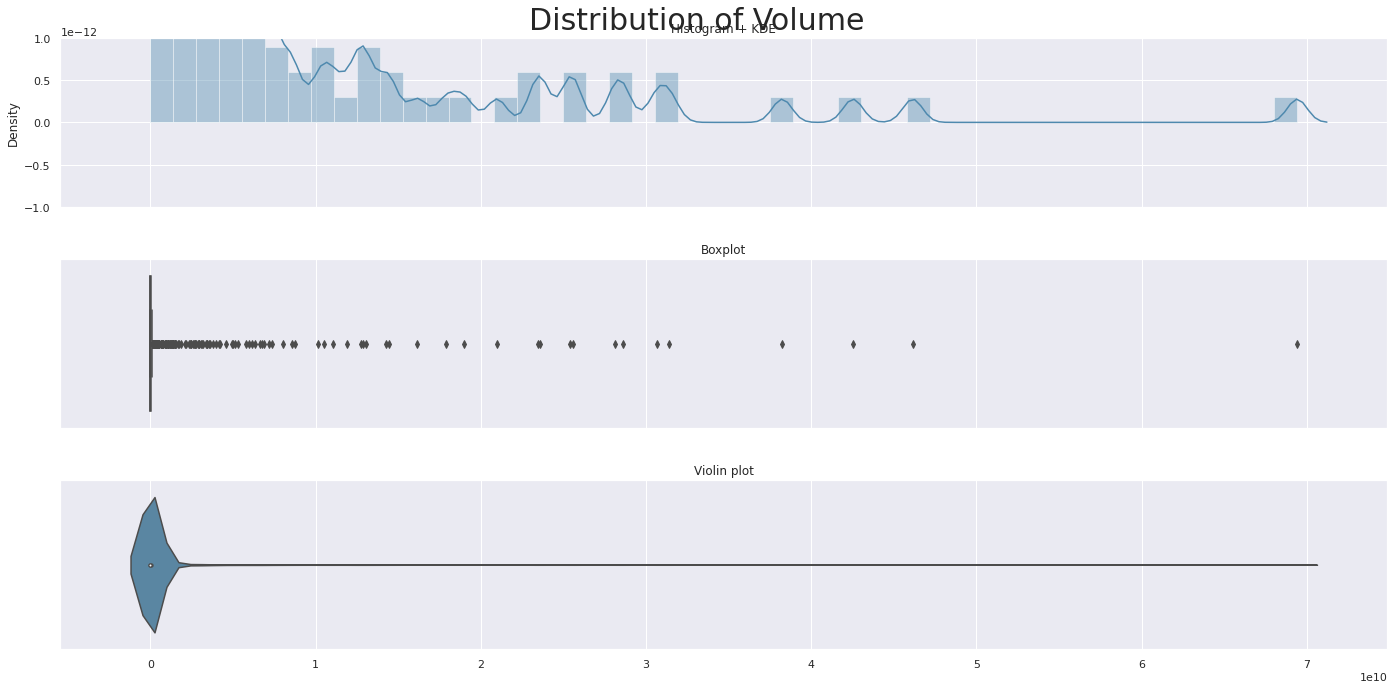

In [45]:
triple_plot(data['Volume'],'Distribution of Volume',custom_colors[0])

<a id="4"></a>
<h2 style='background-color:#6A5ACD; border:0; color:black'><center>Correlation Analysis</center><h2>

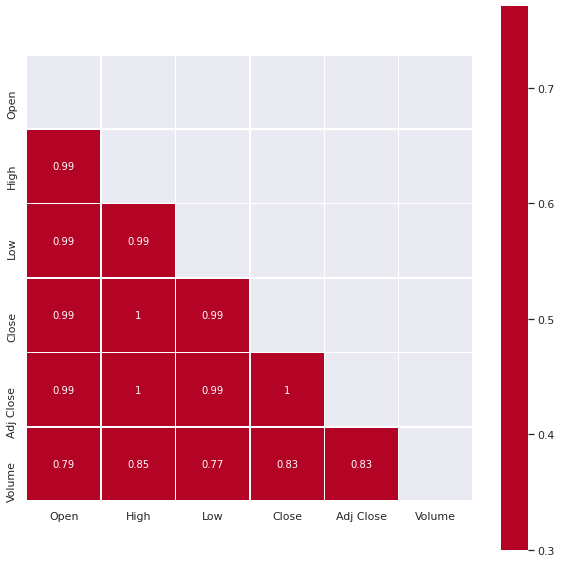

In [46]:
plt.figure(figsize=(10,10))
corr=data[data.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data[data.columns[1:]].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

<div class="alert alert-info">
    <h3><b><center>Correlation Network</center><b></h3>
</div>


In [47]:
indices = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: indices[x])
#G.edges(data=True)

In [48]:
def corr_network(G, corr_direction, min_correlation):
    H = G.copy()

    for s1, s2, weight in G.edges(data=True):       
        if corr_direction == "positive":
            if weight["weight"] < 0 or weight["weight"] < min_correlation:
                H.remove_edge(s1, s2)
        else:
            if weight["weight"] >= 0 or weight["weight"] > min_correlation:
                H.remove_edge(s1, s2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
   
    d = dict(nx.degree(H))
    nodelist=d.keys()
    node_sizes=d.values()
    
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10))

    nx.draw_networkx_nodes(H,positions,node_color='#d100d1',nodelist=nodelist,
                       node_size=tuple([x**4 for x in node_sizes]),alpha=0.8)

    nx.draw_networkx_labels(H, positions, font_size=13)

    if corr_direction == "positive":
        edge_colour = plt.cm.summer 
    else:
        edge_colour = plt.cm.autumn
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

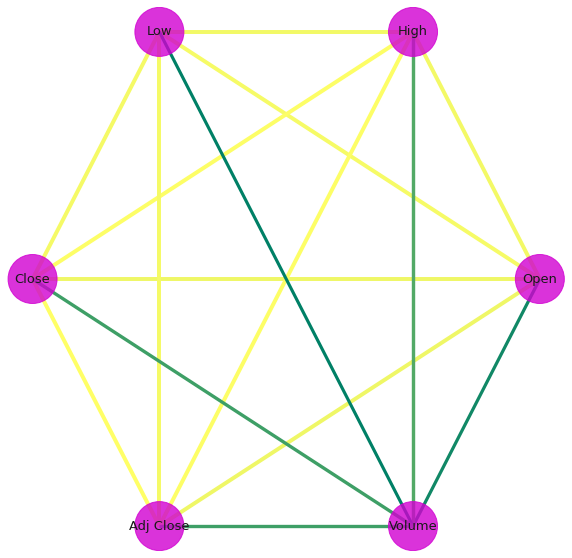

In [49]:
corr_network(G, corr_direction="positive",min_correlation = 0.5)


In [50]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Close'])
                      ])
fig.show()

<div class='alert alert-warning'>
    <h3><center>Input to Prophet is a data frame with minimum two columns : ds and y</center></h3>
</div>

In [51]:
# Renaming the column names accroding to Prophet's requirements
prophet_df=data[['Date','Close']]
prophet_df.rename(columns={'Date':'ds','Close':'y'},inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<div class='alert alert-warning'>
    <h2><center>Creating and fitting the Prophet model with default values</center></h2>
    <h3>We will first explore the default Prophet model. Create the Prophet instance with all default values, fit the dataset.</h3>
</div>

In [52]:
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<div class='alert alert-warning'>
    <h2><center>Predicting the values for the future</center></h2>
<h4>For predicting the values using Prophet, we need to create a dataframe with ds(datetime stamp) containing the dates for which we want to make the predictions.<br><br>
We use make_future_dataframe() to which we specify the number of days to extend into the future. By default it includes dates from the history</h4>
</div>

In [53]:
future= prophet_basic.make_future_dataframe(periods=300)
future.tail(2)

,ds
2722,2022-03-05
2723,2022-03-06


In [54]:
forecast=prophet_basic.predict(future)

<div class='alert alert-warning'>
    <h3><center>Plotting the predicted data</center></h3>
</div>

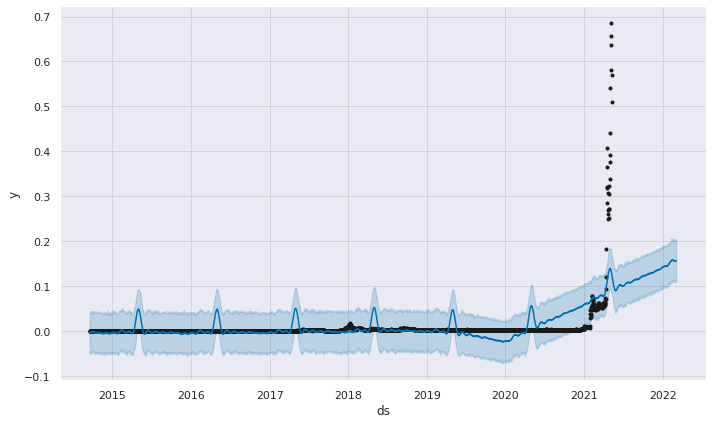

In [55]:
fig1 =prophet_basic.plot(forecast)

<div class='alert alert-warning'>
    <h3><center>Plotting the Forecasted components(Trend and Seasonality)</center></h3>
</div>

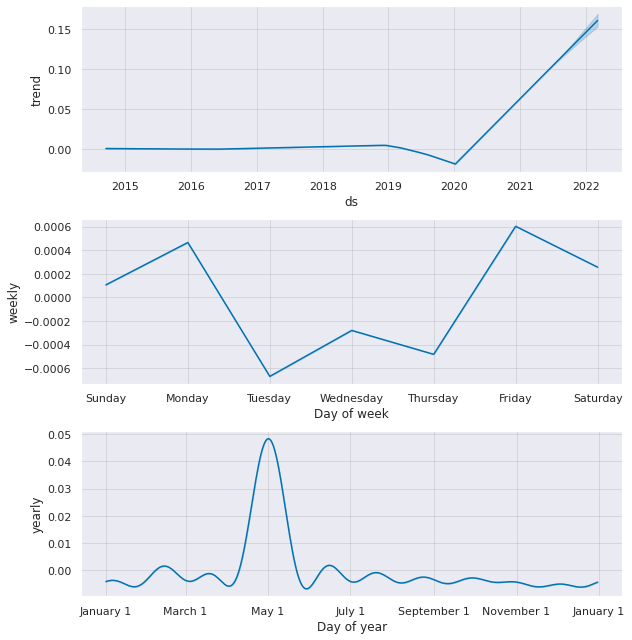

In [56]:
fig1 = prophet_basic.plot_components(forecast)

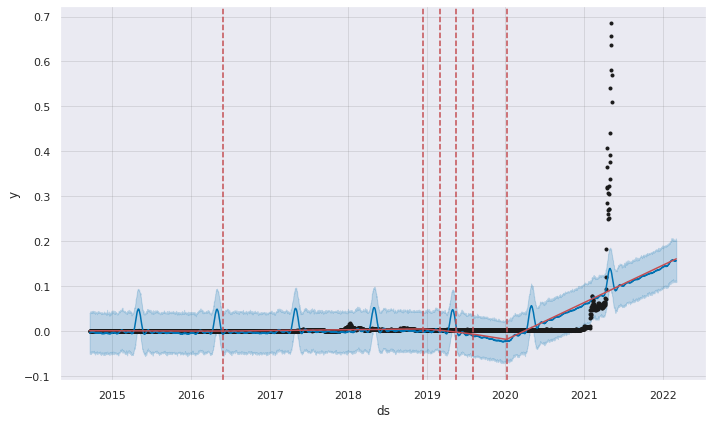

In [57]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

<div class='alert alert-warning'>
        <h3> Following are the Changepoints, where the time series had abrupt changes in the trajectory.</h3>
</div>

In [58]:
print(f'{m_}Change points:\n {y_}{prophet_basic.changepoints}\n')

Change points:
 78     2014-12-04
155    2015-02-19
233    2015-05-08
310    2015-07-24
388    2015-10-10
465    2015-12-26
543    2016-03-13
620    2016-05-29
698    2016-08-15
775    2016-10-31
853    2017-01-17
930    2017-04-04
1008   2017-06-21
1085   2017-09-06
1163   2017-11-23
1240   2018-02-08
1318   2018-04-27
1395   2018-07-13
1473   2018-09-29
1550   2018-12-15
1628   2019-03-03
1705   2019-05-19
1783   2019-08-05
1860   2019-10-21
1938   2020-01-07
Name: ds, dtype: datetime64[ns]



<div class='alert alert-warning'>
    <h2><center>Adding Multiple Regressors</center></h2>
<h3>Additional regressors can be added to the Prophet model. This is done by using add_regressor. Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.<h3>
    <h3><center>Creating fitting and predicting dataset with additional regressors</center></h3>
    </div>

In [59]:
prophet_df['Open'] = data['Open']
prophet_df['High'] = data['High']
prophet_df['Low'] = data['Low']
prophet_df['Vol'] = data['Volume']

prophet_df=prophet_df.dropna()
train_X= prophet_df[:1500]
test_X= prophet_df[1500:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [60]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Vol')



In [61]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


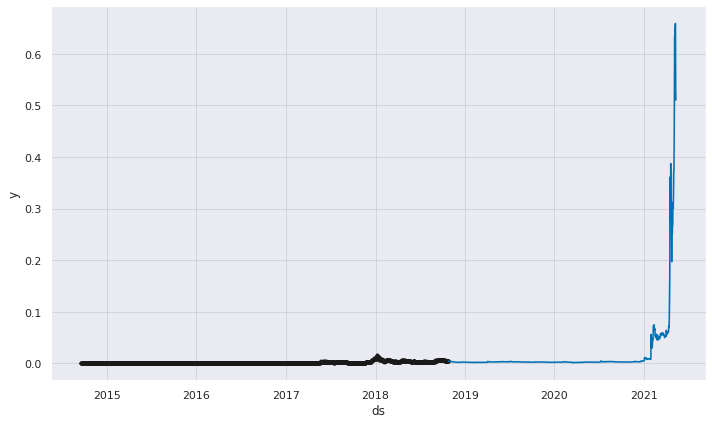

In [62]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

In [63]:
forecast_data.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,High,High_lower,High_upper,Low,Low_lower,Low_upper,Open,Open_lower,Open_upper,Vol,Vol_lower,Vol_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
919,2021-05-06,0.001510,0.577663,0.577948,0.001435,0.00158,0.522482,0.522482,0.522482,0.341105,0.341105,0.341105,-0.282091,-0.282091,-0.282091,-0.005209,-0.005209,-0.005209,0.576295,0.576295,0.576295,0.576287,0.576287,0.576287,-0.000006,-0.000006,-0.000006,0.000014,0.000014,0.000014,0.0,0.0,0.0,0.577805
920,2021-05-07,0.001511,0.644405,0.644702,0.001435,0.00158,0.576424,0.576424,0.576424,0.325467,0.325467,0.325467,-0.251027,-0.251027,-0.251027,-0.007851,-0.007851,-0.007851,0.643039,0.643039,0.643039,0.643013,0.643013,0.643013,0.000012,0.000012,0.000012,0.000013,0.000013,0.000013,0.0,0.0,0.0,0.644549
921,2021-05-08,0.001511,0.658640,0.658939,0.001435,0.00158,0.580839,0.580839,0.580839,0.380667,0.380667,0.380667,-0.297230,-0.297230,-0.297230,-0.007011,-0.007011,-0.007011,0.657280,0.657280,0.657280,0.657266,0.657266,0.657266,0.000001,0.000001,0.000001,0.000012,0.000012,0.000012,0.0,0.0,0.0,0.658790
922,2021-05-09,0.001511,0.529511,0.529809,0.001434,0.00158,0.549319,0.549319,0.549319,0.266206,0.266206,0.266206,-0.274719,-0.274719,-0.274719,-0.012659,-0.012659,-0.012659,0.528154,0.528154,0.528154,0.528146,0.528146,0.528146,-0.000004,-0.000004,-0.000004,0.000012,0.000012,0.000012,0.0,0.0,0.0,0.529665
923,2021-05-10,0.001511,0.510412,0.510691,0.001434,0.00158,0.446288,0.446288,0.446288,0.310371,0.310371,0.310371,-0.241150,-0.241150,-0.241150,-0.006474,-0.006474,-0.006474,0.509041,0.509041,0.509041,0.509036,0.509036,0.509036,-0.000006,-0.000006,-0.000006,0.000011,0.000011,0.000011,0.0,0.0,0.0,0.510552


<div class='alert alert-warning'>
<h3><center>6 different types of metrics are shown by each time horizon, but by taking moving average over 37 days in this case (can be changed by ‘rolling_window’ option).</center></h3>
</div>

INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-05-09 00:00:00 and 2017-10-25 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,7.635478e-09,0.000087,0.000035,0.065057,0.015801,0.605023
1,38 days,7.952793e-09,0.000089,0.000036,0.065998,0.016601,0.591324
2,39 days,7.984445e-09,0.000089,0.000037,0.066103,0.016934,0.589041
3,40 days,8.010487e-09,0.000090,0.000037,0.066558,0.016601,0.584475
4,41 days,8.434047e-09,0.000092,0.000039,0.067644,0.016934,0.579909


,horizon,mse,rmse,mae,mape,mdape,coverage
324,361 days,1.200514e-08,0.000110,0.000072,0.185614,0.020650,0.303653
325,362 days,1.194214e-08,0.000109,0.000072,0.185498,0.020450,0.312785
326,363 days,1.248331e-08,0.000112,0.000073,0.185612,0.020621,0.319635
327,364 days,1.243915e-08,0.000112,0.000072,0.185513,0.020473,0.326484
328,365 days,1.237415e-08,0.000111,0.000072,0.185606,0.020650,0.328767


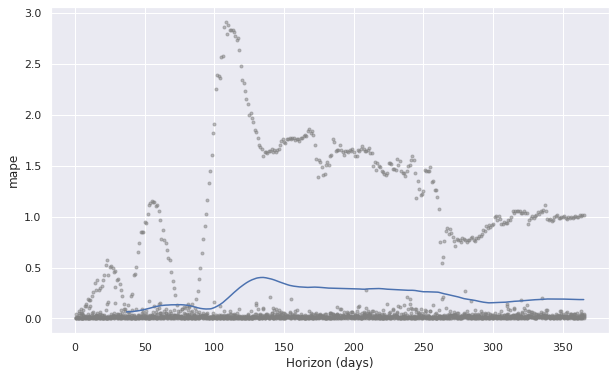

In [64]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()